# Simple Anomaly detection with H2O in Python

### About dataset: 
This data is a collection of metrics of various students a state of India. The goal was to gather as much information possible to determine if a given student would continue his/her schooling or dropout. Future dropout rates and ways to minimize this, was the ultimate goal of the data collection.

We would want Autoencoding and Anomaly detction from H2O, to differentiate the data between students who dropped out and of those who did not. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,Normalizer
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
from pylab import rcParams
rcParams['figure.figsize']=15,10

[WARNING] H2O requires colorama module of version 0.3.8 or newer. You have version 0.3.7.
You can upgrade to the newest version of the module running from the command line
    $ pip3 install --upgrade colorama


In [2]:
student=pd.read_csv('../input/studentDropIndia_20161215.csv', sep=',')
student.isnull().any()

continue_drop         False
student_id            False
gender                False
caste                 False
mathematics_marks     False
english_marks         False
science_marks         False
science_teacher       False
languages_teacher     False
guardian              False
internet              False
school_id             False
total_students        False
total_toilets          True
establishment_year     True
dtype: bool

As shown above, *total_toilets *and *establishment_year* have Null values

In [3]:
#student.dtypes
#student[pd.isnull(student).any(axis=1)]

## Basic exploratory data analysis

### Fill NA with 0

In [4]:
student=student.fillna(0)

### Print correlation matrix

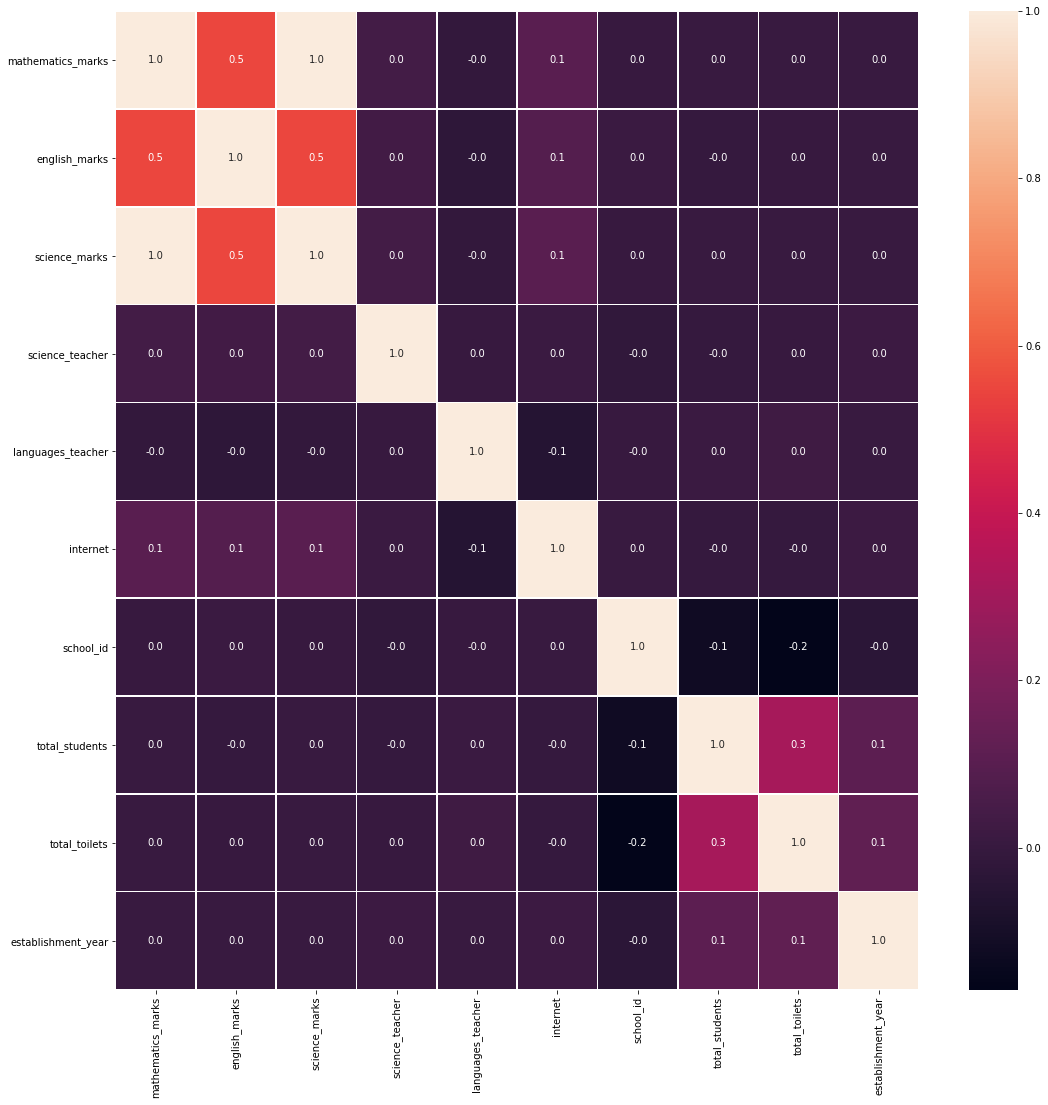

In [5]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(student.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Students' Marks in Math is absolutely correlated with Science 

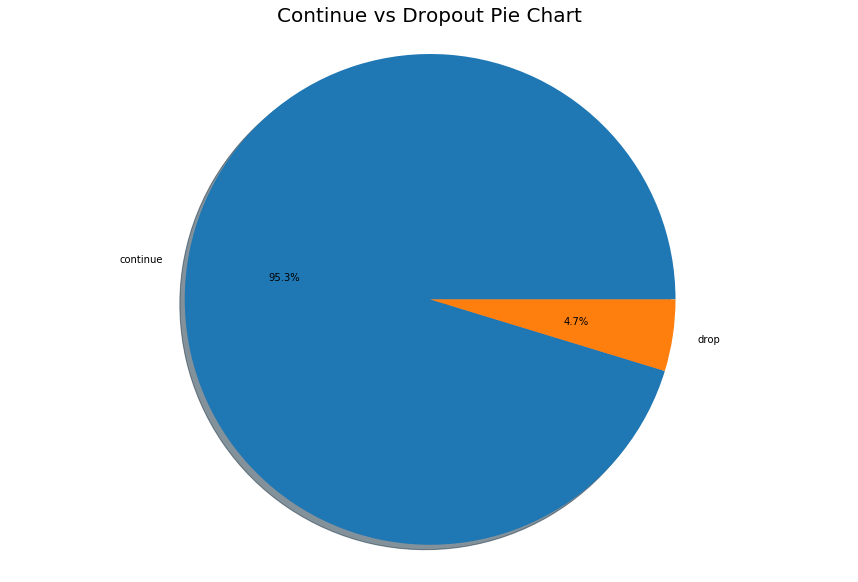

In [6]:
labels = ['continue', 'drop']
sizes = [student['continue_drop'].value_counts()[0],
         student['continue_drop'].value_counts()[1]
        ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Continue vs Dropout Pie Chart', fontsize=20)
plt.show()

95.3% Students continued in school, whereas 4.7% dropped

### List column

In [7]:
predictors=list(range(0,15))
print(student.shape)

(19100, 15)


### H2O cannot use columns with character datatype. Creating Dummy variables instead

In [8]:
cols_to_transform = [ 'continue_drop','gender','caste','guardian','internet' ]
student = pd.get_dummies( student,columns = cols_to_transform )
student.head()

,student_id,mathematics_marks,english_marks,science_marks,science_teacher,languages_teacher,school_id,total_students,total_toilets,establishment_year,...,caste_BC,caste_OC,caste_SC,caste_ST,guardian_father,guardian_mixed,guardian_mother,guardian_other,internet_False,internet_True
0,s00001,0.409,0.514,0.409,6,0,310,262,28.0,1985.0,...,0,0,1,0,0,0,1,0,0,1
1,s00002,0.290,0.512,0.290,4,7,328,356,14.0,1943.0,...,1,0,0,0,0,0,1,0,0,1
2,s00003,0.602,0.666,0.602,4,2,322,179,8.0,1955.0,...,0,1,0,0,0,0,1,0,1,0
3,s00004,0.378,0.526,0.378,8,7,305,354,86.0,1986.0,...,1,0,0,0,0,0,1,0,0,1
4,s00005,0.536,0.614,0.536,9,4,360,273,2.0,1995.0,...,0,1,0,0,0,0,0,1,0,1


### Dropping student_id column

In [9]:
student = student.drop('student_id', 1)

### Ensuring all the columns are of numeric datatype

In [10]:
student.dtypes

mathematics_marks         float64
english_marks             float64
science_marks             float64
science_teacher             int64
languages_teacher           int64
school_id                   int64
total_students              int64
total_toilets             float64
establishment_year        float64
continue_drop_continue      uint8
continue_drop_drop          uint8
gender_F                    uint8
gender_M                    uint8
caste_BC                    uint8
caste_OC                    uint8
caste_SC                    uint8
caste_ST                    uint8
guardian_father             uint8
guardian_mixed              uint8
guardian_mother             uint8
guardian_other              uint8
internet_False              uint8
internet_True               uint8
dtype: object

### Standardize input data

In [11]:
# Copy the original dataset
scaled_features = student.copy()

# Extract column names to be standardized
col_names = ['mathematics_marks','english_marks','science_marks',
             'science_teacher','languages_teacher','school_id',
             'total_students','total_toilets','establishment_year'#,
             #'gender_F','gender_M','caste_BC','caste_OC','caste_SC',
             #'caste_ST','guardian_father','guardian_mixed','guardian_mother',
            # 'guardian_other','internet_False','internet_True'
            ]

# Standardize the columns and re-assingn to original dataframe
features = scaled_features[col_names]
scaler = RobustScaler().fit_transform(features.values)
features = pd.DataFrame(scaler, index=student.index, columns=col_names)
scaled_features [col_names] = features
scaled_features.head()

,mathematics_marks,english_marks,science_marks,science_teacher,languages_teacher,school_id,total_students,total_toilets,establishment_year,continue_drop_continue,...,caste_BC,caste_OC,caste_SC,caste_ST,guardian_father,guardian_mixed,guardian_mother,guardian_other,internet_False,internet_True
0,-0.352159,-0.209677,-0.352159,0.50,-1.25,-0.790698,0.000000,0.928571,0.967213,1,...,0,0,1,0,0,0,1,0,0,1
1,-0.747508,-0.218894,-0.747508,0.00,0.50,-0.372093,0.454106,-0.071429,0.278689,1,...,1,0,0,0,0,0,1,0,0,1
2,0.289037,0.490783,0.289037,0.00,-0.75,-0.511628,-0.400966,-0.500000,0.475410,1,...,0,1,0,0,0,0,1,0,1,0
3,-0.455150,-0.154378,-0.455150,1.00,0.50,-0.906977,0.444444,5.071429,0.983607,1,...,1,0,0,0,0,0,1,0,0,1
4,0.069767,0.251152,0.069767,1.25,-0.25,0.372093,0.053140,-0.928571,1.131148,1,...,0,1,0,0,0,0,0,1,0,1


### Split dataset - dropped students as 'test' and continued students as 'train'

In [12]:
#student = student.astype(object)

train=scaled_features.loc[scaled_features['continue_drop_continue'] == 1]
test=scaled_features.loc[scaled_features['continue_drop_drop'] == 1]

## H2O Autoencoding and Anomaly detection

### Starting H2O cluster

In [13]:
h2o.init(nthreads=-1, enable_assertions = False)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /opt/conda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpl4jgvh8d
  JVM stdout: /tmp/tmpl4jgvh8d/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpl4jgvh8d/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,21 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_unknownUser_z0u4tv
H2O cluster total nodes:,1
H2O cluster free memory:,25.14 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


### Convert panda dataframe to H2O dataframe

In [14]:
train.hex=h2o.H2OFrame(train)
test.hex=h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


### Create AutoEncoder Model

In [15]:
model=H2OAutoEncoderEstimator(activation="Tanh",
                              hidden=[120],
                              ignore_const_cols=False,
                              epochs=100
                             )

### Train the model with training dataset

In [16]:
model.train(x=predictors,training_frame=train.hex)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


### Print the output in JSON format

In [17]:
model._model_json['output']

Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 3,735 weights/biases, 49.8 KB, 1,599,356 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,15,Input,0.0,,,,,,,,,
,2,120,Tanh,0.0,0.0,0.0,0.4575394,0.4220418,0.0,0.0121450,0.5013216,0.0915840,3.2970648
,3,15,Tanh,,0.0,0.0,0.0087320,0.0070449,0.0,0.0140926,1.0591788,-1.2450242,3.9576788


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
,2018-01-29 14:50:43,7.389 sec,0.00000 obs/sec,0.0,0,0.0,0.3257642,0.1061223
,2018-01-29 14:51:09,31.980 sec,8199 obs/sec,10.9903846,2,200025.0,0.2630535,0.0691972
,2018-01-29 14:51:17,40.776 sec,9084 obs/sec,16.4775275,3,299891.0,0.1198554,0.0143653
,2018-01-29 14:51:26,49.411 sec,9601 obs/sec,21.96,4,399672.0,0.0564967,0.0031919
,2018-01-29 14:51:35,58.076 sec,9945 obs/sec,27.4495055,5,499581.0,0.0354627,0.0012576
,2018-01-29 14:51:43,1 min 6.769 sec,10183 obs/sec,32.9461538,6,599620.0,0.0416567,0.0017353
,2018-01-29 14:51:52,1 min 14.968 sec,10437 obs/sec,38.4412088,7,699630.0,0.0173405,0.0003007
,2018-01-29 14:52:00,1 min 23.590 sec,10571 obs/sec,43.9353846,8,799624.0,0.0234726,0.0005510
,2018-01-29 14:52:09,1 min 32.221 sec,10676 obs/sec,49.4301648,9,899629.0,0.0225665,0.0005092
,2018-01-29 14:52:17,1 min 40.702 sec,10779 obs/sec,54.9247253,10,999630.0,0.0199359,0.0003974



ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.00029249797380168546
RMSE: 0.017102572139935136
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
gender_F,1.0,1.0,0.1277258
caste_BC,0.9153978,0.9153978,0.1169199
gender_M,0.8684902,0.8684902,0.1109286
caste_OC,0.7028925,0.7028925,0.0897775
school_id,0.5419067,0.5419067,0.0692155
total_students,0.4788920,0.4788920,0.0611669
total_toilets,0.4686745,0.4686745,0.0598618
science_marks,0.4369027,0.4369027,0.0558037
establishment_year,0.4209473,0.4209473,0.0537658
languages_teacher,0.4067972,0.4067972,0.0519585


{'__meta': {'schema_name': 'DeepLearningModelOutputV3',
  'schema_type': 'DeepLearningModelOutput',
  'schema_version': 3},
 'biases': None,
 'catoffsets': None,
 'cross_validation_fold_assignment_frame_id': None,
 'cross_validation_holdout_predictions_frame_id': None,
 'cross_validation_metrics': None,
 'cross_validation_metrics_summary': None,
 'cross_validation_models': None,
 'cross_validation_predictions': None,
 'domains': [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'end_time': 1517237587887,
 'help': {'__meta': 'Metadata on this schema instance, to make it self-describing.',
  'biases': 'Frame keys for bias vectors',
  'catoffsets': 'Categorical offsets for one-hot encoding',
  'cross_validation_fold_assignment_frame_id': 'Cross-validation fold assignment (each row is assigned to one holdout fold)',
  'cross_validation_holdout_predictions_frame_id': 'Cross-validation holdout predictions (full out-of-sam

### Get anomalous values

In [18]:
test_rec_error=model.anomaly(test.hex)
train_rec_error=model.anomaly(train.hex)

### Convert output to dataframe

In [19]:
test_rec_error_df=test_rec_error.as_data_frame()
train_rec_error_df=train_rec_error.as_data_frame()
final = pd.concat([train_rec_error_df, train_rec_error_df])

### Calculate top whisker value

In [20]:
boxplotEdges=final.quantile(.75)
iqr = np.subtract(*np.percentile(final, [75, 25]))
top_whisker=boxplotEdges[0]+(1.5*iqr)
top_whisker

0.00061607203688951256

### Add id column to dataframe 

In [21]:
train_rec_error_df['id']=train_rec_error_df.index
test_rec_error_df['id']=test_rec_error_df.index + 18200 #Count of train data

### Scatter plot with top whisker

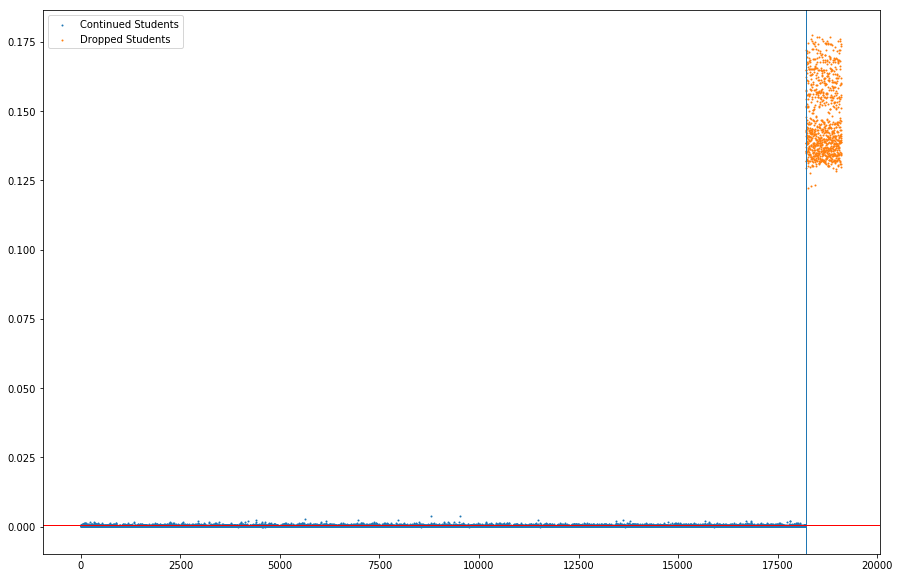

In [22]:
plt.scatter(train_rec_error_df['id'],train_rec_error_df['Reconstruction.MSE'],label='Continued Students',s=1)
plt.axvline(x=18200,linewidth=1)
plt.scatter(test_rec_error_df['id'],test_rec_error_df['Reconstruction.MSE'],label='Dropped Students',s=1)
plt.axhline(y=top_whisker,linewidth=1, color='r')
plt.legend()

## Output:

We have trained the model to detel the students who continued in school. From the graph you can see ***all the students who dropped*** have been correctly classfifed as **Outliers**

In [23]:
h2o.cluster().shutdown()

H2O session _sid_8199 closed.


## Reference :
https://charleshsliao.wordpress.com/2017/06/26/denoise-with-auto-encoder-of-h2o-in-python-for-mnist/
http://benalexkeen.com/feature-scaling-with-scikit-learn/